<a href="https://colab.research.google.com/github/IrisFDTD/AI-UNIZAR-course/blob/main/minst/ai_unizar_course_classifying_digits_23-24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">*Introducción a la inteligencia artificial: redes neuronales avanzadas con Tensorflow-Keras*</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Sergio Gutiérrez Rodrigo (sergut@unizar.es)</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Licencia Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>.

```
Sergio G Rodrigo
Departamento de Física Aplicada
Universidad de Zaragoza
Instituto de Nanociencia y Materiales de Aragón (INMA)
C/ Pedro Cerbuna, 12, 50009, Zaragoza, España
```






# **Advanced Neural Networks with TensorFlow-Keras**

---
# **Handwritten digit classification with Convolutional Neural Networks (CNN)**
---


# Auxiliary functions

In [ ]:
%matplotlib inline
import numpy as np
import random

# Two functions for digits visualization
def show_one_digit(digit, npixelsx):
    import matplotlib.pyplot as plt
    plt.figure(dpi=50)
    plt.imshow(digit.reshape([npixelsx, npixelsx]))
    plt.show()

def show_n_m_digits(n, m, digits, labels, npixels_x):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(n*2, m*2))
    columns = n
    rows = m
    ax = []
    for i in range(columns*rows):
        img = digits[i,:].reshape([npixels_x,npixels_x])
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title("label:"+str(labels[i]))  # set title
        plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
        plt.imshow(img)
    plt.show()

# An alternative to GraphData() function
def plot_score(pathresults,history_keras,loss_name,metrics_name):
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    history_dict=history_keras.history
    training_cost=history_dict[loss_name]
    training_accuracy=history_dict[metrics_name]
    evaluation_cost=history_dict['val_'+loss_name]
    evaluation_accuracy=history_dict['val_'+metrics_name]

    epochs=len(evaluation_cost)
    print("Número de épocas: %d\n" % (epochs))
    xx = np.linspace(0,epochs-1,epochs)
    # in a file
    filemse="/loss_mse_.dat"
    file=os.path.exists(pathresults+filemse)
    if (file):
        os.remove(pathresults+filemse)
        print(pathresults+filemse+" removed")
    with open(pathresults+filemse, 'w') as f1:
       for i in range(0,epochs):
           summary= str(xx[i])+' '+str(evaluation_cost[i])+' '+str(evaluation_accuracy[i])+' '+str(training_cost[i])+' '+str(training_accuracy[i])+''+'\n'
           f1.write(summary)
    f1.close()

    # as a figure
    # Four axis
    fig2, ax2 = plt.subplots(2,2, figsize=(6,6)) #sharex='col', sharey='row',
    ax2[0,0].plot(xx,evaluation_cost, color="red", label="Loss (validation)")
    ax2[0,1].plot(xx,evaluation_accuracy, color="blue", label="Metrics (validation)")
    ax2[1,0].plot(xx,training_cost, color="orange", label="Loss (training)")
    ax2[1,1].plot(xx,training_accuracy, color="cyan", label="Metrics (training)")
    txt = "Epochs"
    ax2[0,0].set_xlabel(txt)
    ax2[0,0].legend()
    ax2[0,1].set_xlabel(txt)
    ax2[0,1].legend()
    ax2[1,0].set_xlabel(txt)
    ax2[1,0].legend()
    ax2[1,1].set_xlabel(txt)
    ax2[1,1].legend()
    fig2.savefig(pathresults+"/epochs_evolution.png", dpi=200, facecolor="#f1f1f1")

def inverse_one_hot_enconding(y_enconded):
     y = np.argmax(y_enconded,axis=1)
     return y

def fail_to_predict(model,model_name,x,y):
    y_pred=model.predict(x)
    y_pred_num=inverse_one_hot_enconding(y_pred)
    y_true_num=inverse_one_hot_enconding(y)
    dif=list(y_pred_num-y_true_num)
    fail_to_predict_index=[indx for indx,val in enumerate(dif) if val!=0]
    accu=(len(y)-len(fail_to_predict_index))/len(y)
    print("Model %s FAILED to predict %.f labels out of %.f. Accuracy= %.4f \n" %(model_name,len(fail_to_predict_index),len(y),accu))
    return fail_to_predict_index

def show_wierd_digits(model_filename,x,y,no_digits,npixelsx,verbose=0):
    model=models.load_model(model_filename)
    fail_to_predict_index=fail_to_predict(model,model_filename,x,y)
    n=no_digits
    x_fail=x[fail_to_predict_index[0:n**2]]
    y_fail=y[fail_to_predict_index[0:n**2]]
    y_fail=inverse_one_hot_enconding(y_fail)
    y_fail=np.reshape(y_fail,(y_fail.shape[0],1))
    if(verbose==1):
      model.summary()
      show_n_m_digits(n,n, x_fail, y_fail,npixelsx)
    return  model,fail_to_predict_index

def show_activations_conv2d(layer,x,y1h,ndigits_x,ndigits_y):
  '''
  A function to visualize intermediate activations
  '''
  layer_channels=layer.shape[3]
  layer_size=layer.shape[2]
  pixels=int(np.sqrt(x.shape[1]))
  print("pixels=",pixels)

  # Choose a channel from a given conv2d (or related)
  channel=input("Take a channel from 0 to "+str(layer_channels-1)+": ")

  # Show the digits
  y_test_num=inverse_one_hot_enconding(y1h)
  y_test_num=np.reshape(y_test_num,(y1h.shape[0],1))
  print(x.shape)
  show_n_m_digits(ndigits_x,ndigits_y, x, y_test_num,pixels)

  # Show the activation layer for the chosen channel
  show_me_this=layer[:,:,:,int(channel)]
  show_n_m_digits(ndigits_x,ndigits_y, show_me_this, y_test_num,layer_size)

# Load training and validation datasets (MINST)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_val, y_val) = mnist.load_data()

output_neurons=10 # Output in the range of [0,9]

n_train=50000   # <= 50000
n_val=10000    # <= 10000

# A subset of training/test data
x_train= x_train[0:n_train]
y_train=y_train[0:n_train]
x_val= x_val[0:n_val]
y_val=y_val[0:n_val]

x_train_len=len(x_train)
x_val_len=len(x_val)
print("(train _len,test len)=",x_train_len,x_val_len)
x_train = x_train.reshape(x_train_len, 784)
x_val = x_val.reshape(x_val_len, 784)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(train _len,test len)= 50000 10000


## A look at the data structure

In [ ]:
x=x_train
y=y_train
print('number of images', x.shape[0])
print('number of pixels', x.shape[1])
print('different labels', np.unique(y))
print('number of instances of each pixel', [np.count_nonzero(y == i) for i in np.unique(y)])

number of images 50000
number of pixels 784
different labels [0 1 2 3 4 5 6 7 8 9]
number of instances of each pixel [4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988]


## Shuffle the data

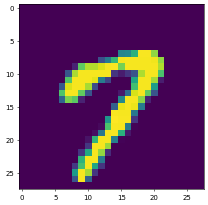

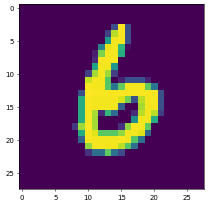

In [ ]:
# shuffle the data
nimagenes=x_train.shape[0]
npixelsx=28
npixelsy=28

# Show two examples (before randomize)
show_one_digit(x_train[15,:], npixelsx)

# Shuffle training dataset
shuffle_list = np.random.permutation(range(nimagenes))
x_train = x_train[shuffle_list, :]
y_train = y_train[shuffle_list]

# Show two examples (after randomize)
show_one_digit(x_train[15,:], npixelsx)

## One hot enconding

In [ ]:
# convert class vectors to binary class matrices (one hot encoding)
y1h_train = tf.keras.utils.to_categorical(y_train, output_neurons)
y1h_val = tf.keras.utils.to_categorical(y_val, output_neurons)

In [ ]:
print(y_train[0:10])
print(y1h_train[0:10])

[6 4 6 3 7 4 1 2 1 8]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


## Exploring the data

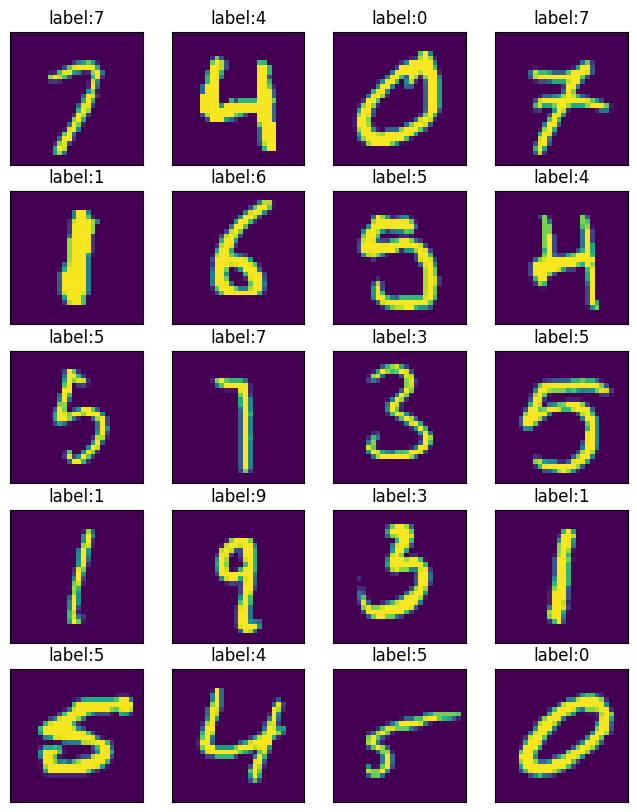

In [ ]:
n = 4; m = 5
show_n_m_digits(n, m, x_train[20:40,:], y_train[20:40], npixelsx)

# **Dense Neural Networks (DNN)**


## Define the model

In [ ]:
# Tensorflow Keras packages
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import SGD

# Check data and labels previously defined
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')
print("x_train shape",x_train.shape)
print("y1h_train shape",y1h_train.shape)

# Input and output neurons (from the data)
input_neurons  = x_train.shape[1]
output_neurons = y1h_train.shape[1]

# Hiperparameters
batch_size = 10
epochs = 10
eta = 1.0
hidden_layer_neurons=15

# Define the model
model = Sequential()
model.add(Input(shape=(input_neurons,)))
model.add(Dense(hidden_layer_neurons, activation='sigmoid'))
model.add(Dense(output_neurons, activation='sigmoid'))

optimizer=SGD(learning_rate=eta)

model.compile(loss='categorical_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy'])

model.summary()

50000 train samples
10000 test samples
x_train shape (50000, 784)
y1h_train shape (50000, 10)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 15)                  │          11,775 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,935 (46.62 KB)

 Trainable params: 11,935 (46.62 KB)

 Non-trainable params: 0 (0.00 B)

## Run the model

In [ ]:
history = model.fit(x_train, y1h_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y1h_val))

Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8422 - loss: 0.5153 - val_accuracy: 0.9201 - val_loss: 0.2964
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9130 - loss: 0.3001 - val_accuracy: 0.9307 - val_loss: 0.2430
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9234 - loss: 0.2663 - val_accuracy: 0.9249 - val_loss: 0.2750
Epoch 4/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9303 - loss: 0.2361 - val_accuracy: 0.9226 - val_loss: 0.2632
Epoch 5/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9337 - loss: 0.2262 - val_accuracy: 0.9315 - val_loss: 0.2434
Epoch 6/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9350 - loss: 0.2204 - val_accuracy: 0.9316 - val_loss: 0.2459
Epoch 7/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9351 - loss: 0.2144 - val_accuracy: 0.9288 - val_loss: 0.2453
Epoch 8/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9408 - loss: 0.2

Keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Número de épocas: 10



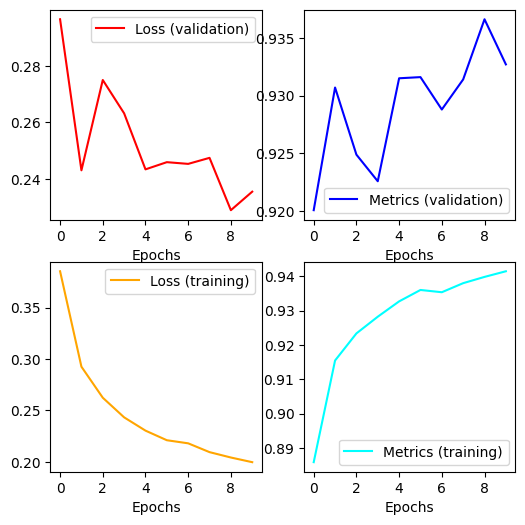

In [ ]:
# Save the model
model.save('./model_dense_simple.keras')

# History from training
print("Keys:",history.history.keys())
plot_keys=list(history.history.keys())
plot_score("./",history,loss_name=plot_keys[1],metrics_name=plot_keys[0])

## **Plotting the results: model summary, score and performance** <a name="Plots"></a>

In [ ]:
from tensorflow.keras import models

model=models.load_model('./model_dense_simple.keras')
model.summary()
score = model.evaluate(x_val, y1h_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 15)                  │          11,775 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,937 (46.63 KB)

 Trainable params: 11,935 (46.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Test loss: 0.23546992242336273
Test accuracy: 0.932699978351593


## Extract weights and bias: a custom feed-forward model

In [ ]:
# Obtain all model weights and bias
model.weights

[<KerasVariable shape=(784, 15), dtype=float32, path=dense/kernel>,
 <KerasVariable shape=(15,), dtype=float32, path=dense/bias>,
 <KerasVariable shape=(15, 10), dtype=float32, path=dense_1/kernel>,
 <KerasVariable shape=(10,), dtype=float32, path=dense_1/bias>]

In [ ]:
# Let's use Keras functional API: a feed forward function
def feed_forward(x):
  a=np.reshape(x,(1,x.shape[0]))
  for layer in model.layers:
      w,b=layer.kernel,layer.bias
      a=layer.activation(a@w+b)
  return a

In [ ]:
# Random picked spectrum in validation
j=np.random.randint(int(y_val.shape[0]))
print('Random index from validation dataset:',j)
x=x_val[j]
y_exact=y1h_val[j]

# Our feed forward method
y_NN=feed_forward(x)
y_NN=np.squeeze(y_NN) # Remove trivial dimensions

# Keras model.predict
y_NN_keras=model.predict(np.reshape(x,(1,x.shape[0])))

# Results
print('\nPrediction')
print('Exact:')
print(y_exact)
print('\nCustom:')
print(y_NN)
print('\nKeras:')
print(y_NN_keras)

print('\nPrediction (exact,custom FF,Keras):')
print(np.argmax(y_exact),np.argmax(y_NN),np.argmax(y_NN_keras))

Random index from validation dataset: 60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step

Prediction
Exact:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

Custom:
[4.9449045e-02 4.3507627e-01 9.7187948e-01 3.6975610e-01 1.2369163e-01
 9.7180037e-03 6.9172078e-05 9.9999869e-01 1.9481659e-01 9.1231734e-01]

Keras:
[[4.9449045e-02 4.3507636e-01 9.7187948e-01 3.6975607e-01 1.2369166e-01
  9.7179981e-03 6.9171947e-05 9.9999869e-01 1.9481644e-01 9.1231740e-01]]

Prediction (exact,custom FF,Keras):
7 7 7


## How wierd are those digits the model did not catch?

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Model ./model_dense_simple.keras FAILED to predict 673 labels out of 10000. Accuracy= 0.9327 



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 15)                  │          11,775 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,937 (46.63 KB)

 Trainable params: 11,935 (46.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

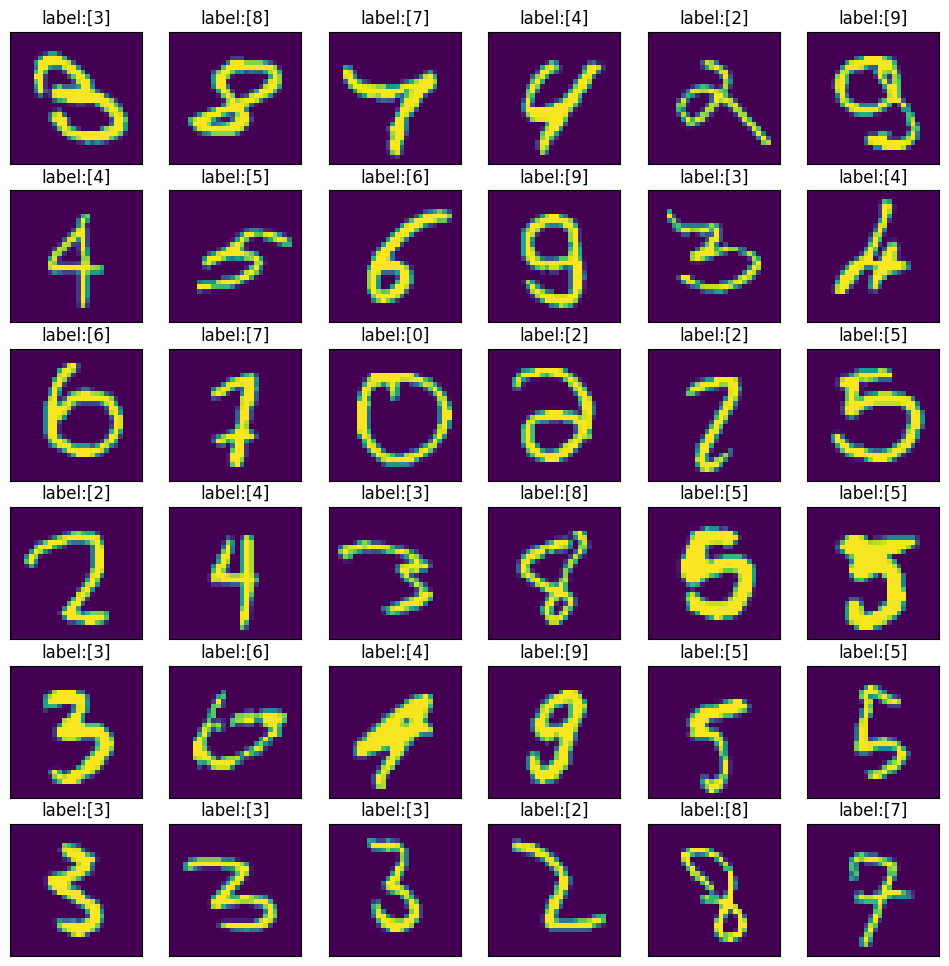

Simple model failed to predict digits  673


In [ ]:
# We load the simple keras model and create a list with digits
# unable to predict by the model
model_dense_simple,fail_to_predict_index_simple=show_wierd_digits('./model_dense_simple.keras',x_val,y1h_val,6,npixelsx,verbose=1)
print("Simple model failed to predict digits ",len(fail_to_predict_index_simple))

# **Convolutional  Neural Networks (CNN)**

## Define the model

In [ ]:
# Tensorflow Keras packages
from tensorflow.keras import models,Model
from tensorflow.keras.layers import Dense, Flatten,Reshape,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Input and output neurons (from the data)
input_neurons  = x_train.shape[1]
output_neurons = y1h_train.shape[1]
print('input neurons=',input_neurons)
print('output neurons=',output_neurons)

input_channels = 1
pixels=28

# Hiperparameters
batch_size = 64
epochs=8

# Define the model
# ----->>> CONV2D
input_conv2d=Input(shape=(input_neurons,))
x=Reshape((pixels,pixels,input_channels),
          input_shape=input_conv2d.shape)(input_conv2d)
x=Conv2D(32,kernel_size=(3, 3),activation='relu')(x)
x=MaxPooling2D((2,2))(x)
x=Conv2D(64, (3, 3), activation='relu')(x)
x=MaxPooling2D((2,2))(x)
x=Conv2D(64, (3, 3), activation='relu')(x)
x=Flatten()(x)
# <<<----- CONV2D

# ----->>> densily connected classifier
x=Dense(64, activation='relu')(x) # new dense layer added
output=Dense(output_neurons, activation='softmax')(x)
# <<<----- densily connected classifier

model=Model(input_conv2d,output)

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

model.summary()

input neurons= 784
output neurons= 10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

## Run the model

In [ ]:
history=model.fit(x_train,y1h_train,
                  epochs=epochs,
                  batch_size=batch_size,\
                  verbose=1,
                  validation_data=(x_val, y1h_val))

Epoch 1/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8527 - loss: 0.4523 - val_accuracy: 0.9850 - val_loss: 0.0468
Epoch 2/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9817 - loss: 0.0556 - val_accuracy: 0.9877 - val_loss: 0.0376
Epoch 3/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9885 - loss: 0.0393 - val_accuracy: 0.9766 - val_loss: 0.0683
Epoch 4/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9914 - loss: 0.0269 - val_accuracy: 0.9903 - val_loss: 0.0296
Epoch 5/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9940 - loss: 0.0202 - val_accuracy: 0.9918 - val_loss: 0.0294
Epoch 6/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9959 - loss: 0.0132 - val_accuracy: 0.9837 - val_loss: 0.0496
Epoch 7/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9963 - loss: 0.0115 - val_accuracy: 0.9910 - val_loss: 0.0309
Epoch 8/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9966 - loss: 0.0102 - val_accuracy: 0.9921 - 

Keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Número de épocas: 8

.//loss_mse_.dat removed


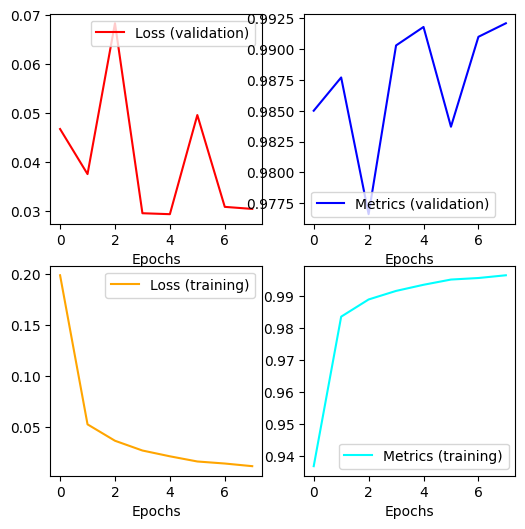

In [ ]:
model.save('./model_conv2d.keras')
# history from training
print("Keys:",history.history.keys())
plot_keys=list(history.history.keys())
plot_score("./",history,loss_name=plot_keys[1],metrics_name=plot_keys[0])

## Plotting the results: model summary, score and performance

In [ ]:
from tensorflow.keras import models

model=models.load_model("./model_conv2d.keras")
model.summary()

score = model.evaluate(x_val, y1h_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,646 (729.09 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 93,324 (364.55 KB)

Test loss: 0.030467653647065163
Test accuracy: 0.9921000003814697


## Extract weights and bias

In [ ]:
for layer in model.layers:
    try :
      w,b=layer.kernel,layer.bias
      print("\n"+layer.name)
      print("kernel shape=",w.shape)
      print("bias shape=",b.shape)
      params=[i for i in w.shape]
      params=np.prod(np.array(params))+b.shape[0]
      print("number of params=",params)
    except:
      print("\n"+layer.name," object has no attribute kernel/bias")


input_layer_1  object has no attribute kernel/bias

reshape  object has no attribute kernel/bias

conv2d
kernel shape= (3, 3, 1, 32)
bias shape= (32,)
number of params= 320

max_pooling2d  object has no attribute kernel/bias

conv2d_1
kernel shape= (3, 3, 32, 64)
bias shape= (64,)
number of params= 18496

max_pooling2d_1  object has no attribute kernel/bias

conv2d_2
kernel shape= (3, 3, 64, 64)
bias shape= (64,)
number of params= 36928

flatten  object has no attribute kernel/bias

dense_2
kernel shape= (576, 64)
bias shape= (64,)
number of params= 36928

dense_3
kernel shape= (64, 10)
bias shape= (10,)
number of params= 650


## How wierd are those digits the model did not catch?

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model model_conv2d.keras FAILED to predict 79 labels out of 10000. Accuracy= 0.9921 



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,646 (729.09 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 93,324 (364.55 KB)

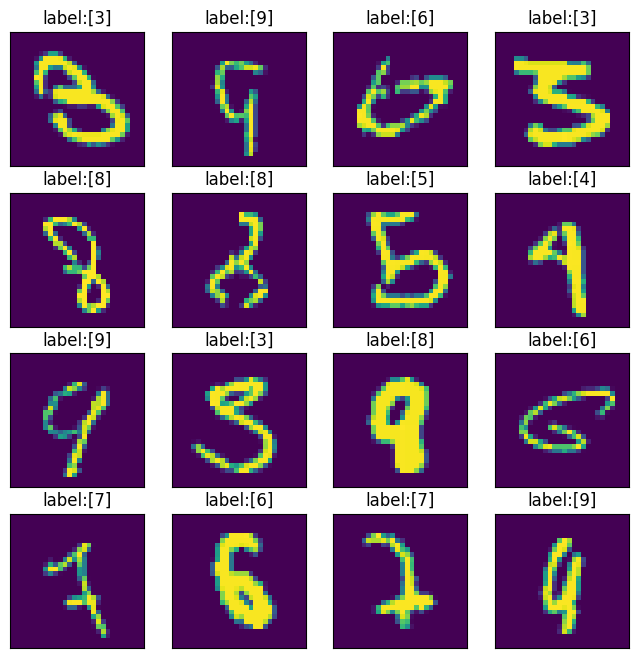

Conv2D model failed to predict digits  79


In [ ]:
# We load the conv2D keras model and create a list with digits
# unable to predict by the model
model_conv2d,fail_to_predict_index_conv2d=show_wierd_digits('model_conv2d.keras',x_val,y1h_val,4,npixelsx,verbose=1)
print("Conv2D model failed to predict digits ",len(fail_to_predict_index_conv2d))

## Visualizing intermediate activations



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,646 (729.09 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 93,324 (364.55 KB)

Layer name's:
Layer number  0  named  input_layer_1
Layer number  1  named  reshape
Layer number  2  named  conv2d
Layer number  3  named  max_pooling2d
Layer number  4  named  conv2d_1
Layer number  5  named  max_pooling2d_1
Layer number  6  named  conv2d_2
Layer number  7  named  flatten
Layer number  8  named  dense_2
Layer number  9  named  dense_3
.... 10 layers in the model
activation_model is: <class 'keras.src.models.functional.Functional'>
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
activations are: <class 'list'>
Choose an image-like outputing layer: 3
pixels= 28
Take a channel from 0 to 31: 0
(10000, 784)


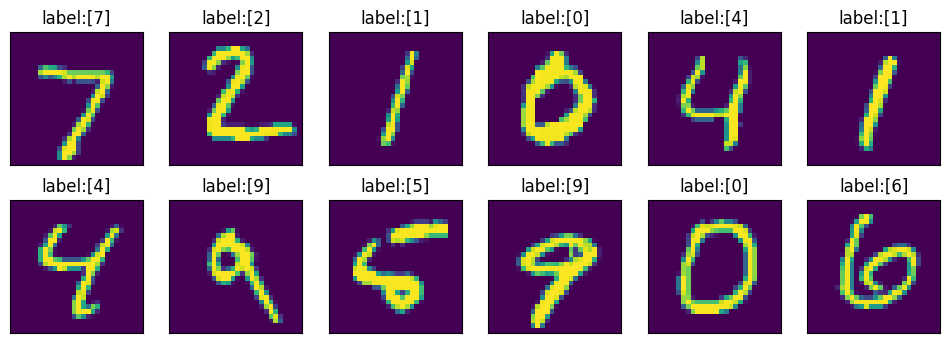

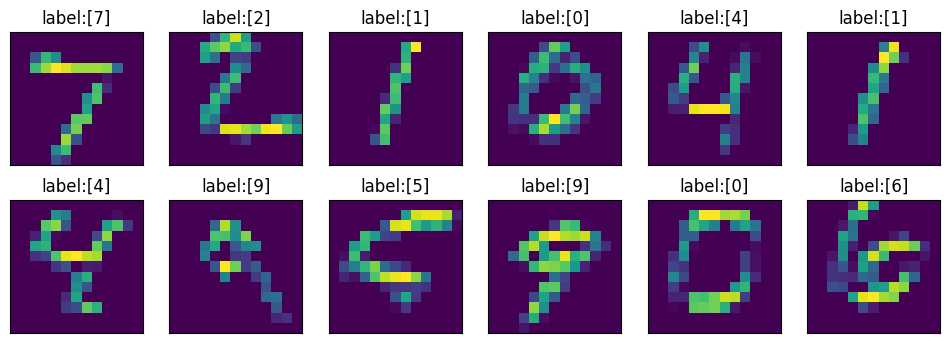

In [ ]:
from tensorflow.keras import models

# Load and show model summary
model=models.load_model('model_conv2d.keras')
model.summary()

# Layer name's are shown
print("Layer name's:")
for i,layer in enumerate(model.layers):
  print("Layer number ",i," named ",layer.name)

# A list with layer outputs are created from model.layers
layers_outputs=[layer.output for layer in model.layers[:]]
print(".... %i layers in the model" %(len(layers_outputs)))


# A list with activations from each layer is created
# Each activation in activation_model outputs the activation for a
# given input x.
activation_model=models.Model(inputs=model.input,outputs=layers_outputs)
print("activation_model is:",type(activation_model))

# The list of keras "models" created allow us to predict the activations
# for all layers in the model.
activations=activation_model.predict(x_val)
print("activations are:",type(activations))

# Choose layer
ilayer=input("Choose an image-like outputing layer: ")
layer=activations[int(ilayer)]

'''
# Alternative method with list comprehension
activation_model2=[Model(inputs=model.input,outputs=output) for output in layers_outputs]
print(type(activation_model2))
activations2=[mdl.predict(x_val) for mdl in activation_model2]
print(type(activations2))
# Choose layer
ilayer=input("Choose an image-like outputing layer: ")
layer=activations2[int(ilayer)]
'''

# Show input images vs activations
show_activations_conv2d(layer,x_val,y1h_val,6,2)